## Imports 

In [68]:
import requests
import os, sys, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import magic
from zipfile import ZipFile
from datetime import datetime,timedelta
import cv2

## Downloading & Loading Datasets

### Set 1: OCT Volumes

The data downloaded here are from the <i>[OCT volumes for glaucoma detection](https://zenodo.org/records/1481223)</i> dataset, published to **Zenodo** by Hiroshi Ishikawa from NYU, one of the authors of <i>[A feature agnostic approach for glaucoma detection in OCT volumes. (PLOS One, 2019)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0219126)</i>

In [6]:
def unzip(zfpath,outpath):
    with ZipFile(zfpath,'r') as zipref:
        if not os.path.exists(outpath):
            os.mkdir(outpath)
        zipref.extractall(outpath)
        print(f'Contents of {os.path.basename(zfpath)} extracted to {outpath}')

def download_datazip(url,dirname,parentDIR='../datasrc/',report_time=True):
    targetPATH = os.path.join(parentDIR,dirname)
    zipfilePATH = targetPATH + '.zip'

    if report_time:
        # Start Time
        t_start = datetime.now()
        
    #-----------------#
    # Download zipfile
    print('Requesting data...')
    response = requests.get(url)
    filesize = sys.getsizeof(response.content)
    with open(zipfilePATH,'wb') as f:
        f.write(response.content)
    print(f'Downloaded zip file ({filesize:,.02f} bytes) to {zipfilePATH}')

    # Extract zip to target path
    try:
        unzip(zipfilePATH,targetPATH)
    except:
        raise NotImplementedError(f"Issue with either locating/creating {targetPATH},\
        extracting {zipfilePATH}, or removing {zipfilePATH} after extraction.")   
        
    # Remove zip file if successful
    os.remove(zipfilePATH)
    print(f'Removed {os.path.basename(zipfilePATH)} after extraction.')
    #-----------------#
    
    if report_time:
        # End Time
        t_end = datetime.now()
        # Time Report
        tdif = (t_end - t_start).total_seconds()
        if tdif > 3600:
            unit = 'hours'
            tdif = tdif / 3600
        elif tdif > 60 and tdif < 3600:
            unit = 'minutes'
            tdif = tdif / 60
        else:
            unit = 'seconds'
        print(f'Time Elapsed: {tdif:.4f} {unit}')

In [5]:
# Download OCT volumes (v for volume)
vURL="https://zenodo.org/records/1481223/files/glaucoma_detection.zip?download=1"
vDIR = 'volumesOCT'
vPATH = os.path.join('../datasrc/',vDIR)
download_datazip(vURL,vDIR)

Downloaded zip file (463,227,815.00 bytes) to ../datasrc/volumesOCT.zip
Contents of volumesOCT.zip extracted to ../datasrc/volumesOCT
Removed volumesOCT.zip after extraction.
Time Elapsed: 11.5526 minutes


#### Dataset Information

***Note: this dataset includes Optic Nerve Head (ONH) centered OCT Scans only.***
- Cirrus SD-OCT Scanner
- Zeiss, Dublin, CA, USA
- 624 patients; 1110 scans; 263 healthy, 847 primary open-angle glaucoma (POAG)
-  Glaucoma Dx Criteria Used:
    -  presence of glaucomatous VF defects (but ultimately CNN will not require VF testing data to classify the OCT scans)
    -  $\ge$ 2 consecutive abnormal test results

- scan dimensions: 6x6x2 mm --> originally 200x200x1024 voxels , but down-sampled to 64x64x128.

###  Set 2: Composite Fundus & OCT Images (2D)

These data come from [A Composite Retinal Fundus and OCT Dataset with Detailed Clinical Markings of Retinal Layers and Retinal Lesions to Grade Macular and Glaucomatous Disorders](https://data.mendeley.com/datasets/trghs22fpg/4), published by Taimur Hassan et al. (National University of Sciences and Technology, Khalifa University of Science and Technology) to **Mendeley**.  Note that this is the 4th version (most recent as of June 2025) published September 22, 2021, while the very first version was released Martch 18, 2021.

In [13]:
# Download zip file for fundus-oct-composite (foc) dataset & extract
focURL = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/trghs22fpg-4.zip"
download_datazip(focURL,'fundus-oct-composite')

# Inside the downloaded zip file is another zip file... so extract again
unzip('../datasrc/fundus-oct-composite/Dataset.zip','../datasrc/fundus-oct-composite/')
os.remove('../datasrc/fundus-oct-composite/Dataset.zip')

# Cut out redundant directory levels
foclongpath = '../datasrc/fundus-oct-composite/Dataset/Dataset/OD/'
focPATH = '/'.join(foclongpath.split('/')[:3])
for i in os.listdir(foclongpath):
    old = os.path.join(foclongpath,i)
    new = os.path.join(focPATH,i)
    os.rename(old,new)

# Discard irrelevant directories
shutil.rmtree(os.path.join(focPATH,'Dataset')
os.listdir('../datasrc/fundus-oct-composite/')

Requesting data...
Downloaded zip file (1,539,361,630.00 bytes) to ../datasrc/fundus-oct-composite.zip
Contents of fundus-oct-composite.zip extracted to ../datasrc/fundus-oct-composite
Removed fundus-oct-composite.zip after extraction.
Time Elapsed: 1.7861 minutes
Contents of Dataset.zip extracted to ../datasrc/fundus-oct-composite/


['Glaucoma', 'Healthy', 'Dataset']

From this point on, will refer to `focPATH` variable for the the path to `fundus-oct-composite/`, and `vPATH` for the path to `volumeOCT/`.

## Set 1 | OCT Volumes - Defining & Cleaning

##### Visualizing numpy image arrays 

The authors created their own [OCT viewer](https://github.com/maet3608/oct-viewer) on github (primarily `matplotlib` based); can look into this later, but for now will simply try to view a central cross-section of a single volume using `matplotlib`.

##### Intro/Background Points from Paper (maybe some need to be transfered to later notebooks)

+ Distance metric: cites use of the [**Mahalanobis distance**](https://www.numberanalytics.com/blog/mahalanobis-distance-machine-learning#google_vignette) which is just a more robust distance metric than Euclidean or Manhattan in some cases, because it takes into account covariance.

+ Key clinically useful markers of glaucoma on OCT are thinning of
    1. Retinal nerve fiber layer (RNFL)
    2. Ganglioin cell with inner plexiform layer (GCIPL)

+ You can use traditional ML techniques like kNN, SVMs, and RFs but need to segment the OCT volumes first (i.e., to get the RNFL and GICPL thicknesses); meanwhile DL techniques like CNNs are feature-agnostic / don't need "human-designed" disease markers...

**Review of Previous Work**

Trad ML models, requiring segmentation:
+ Huang et al. [8] - 89:100 glaucoma:healthy, 25 features(RNFL thickness, vertical rim area, etc.)
+ Silva et al. [9] - 62:48 g:h, 20 features --> 10 classic ML methods, with highest AUC of 0.946 being RF classifier.
+ Kim et al. [11] - 297:202, 7 features ---> RF again was the best, with AUC of 0.979, C5.0.

But accurate segmentation is difficult to come by, especially with low quality scans, advanced glaucoma cases, or other comorbidities like DR,AMD.

DL models:

+ Muhammad et al. [12] - 57:45, CNN w/ similar features like RNFL and GCIPL thickness --> best AUC was like Kim et al. of 0.979; but note the smaller sample size and lack of explicit segmentation.

### Defining Volume Data

It will be important to determine what we actually have in the volume files, including the oriention and what the axes mean.  The actual files for the volume data have `.npy` extensions, so they are easily read as numpy arrays. 

In [15]:
# Get list of all volume numpy filenames
npfilenames = os.listdir(vPATH)

# Some examples of filenames
print(npfilenames[0],'\n',npfilenames[10])

POAG-001978-2012-02-08-OS.npy 
 Normal-000625-2009-12-10-OS.npy


Already, it looks like tabular features are encoded in the filenames themselves - may be useful for Phase 2 if incorporating with other datasets.  Either way, the diagnostic labels of "POAC" (Primary Open-Angle Glaucoma) or "Normal" will be useful for validation.  

In [17]:
# Join filenames with parent path to get list of filepaths (i.e., to conveniently read the numpy arrays)
npfpaths = [ os.path.join(vPATH,name) for name in npfilenames ]

# Example of loading volume file into numpy array
vol = np.load(npfpaths[0])

# View volume dimensions
vol.shape

(64, 128, 64)

(64, 64)


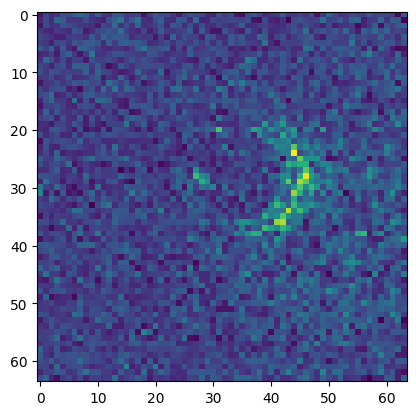

In [18]:
# Subset middle cross-section / slice and render using matplotlib
cxs = vol[:,64,:] # i.e., slice #64 of 128 along axis 1
print(cxs.shape)
plt.imshow(cxs)

This slice along Axis 1 appears to resemble a ciruclar (circumpapillary) scan - i.e., in general anatomical terms, a "coronal" cross-section slicing through the back of the eye where the retina is. Varying the index along this axis will change the depth / which layer of the retina is being rendered.

To view slices along other axes more conveniently, will create function to allow specifiction of normal axis (i.e., in the above case this was axis 1, which was normal to the plane of the image being rendered) along with position of the cross section along said axis as a proportion (number between 0 and 1) of the total length of that axis (e.g., 64px,128px):

In [19]:
def crossSection(npfile_index=0, axis_norm=1,slice_depth=0.5,return_slice=False):
    '''Function for viewing numpy volume file at specific cross section.

    PARAMS:
        npfile_index : index to obtain filename and path
        axis_norm : int from 0-2, indicating axis
            of the volume array to extract a slice from.
        slice_depth : float from 0-1, specifying how far along the
            normal axis (axis_norm) the cross-section/slice 
            is within the volume.        
    '''
    # load volume for given index
    vol = np.load(npfpaths[npfile_index])

    # get cross section based on axis_norm & slice_depth
    if axis_norm == 1:
        cxs_index = vol.shape[1] * slice_depth
        cxs_index = int(cxs_index)
        cxs = vol[:,cxs_index,:]
        other_axes = (0,2)
    elif axis_norm == 0:
        cxs_index = vol.shape[0] * slice_depth
        cxs_index = int(cxs_index)
        cxs = vol[cxs_index,:,:]
        other_axes = (1,2)
    elif axis_norm == 2:
        cxs_index = vol.shape[2] * slice_depth
        cxs_index = int(cxs_index)
        cxs = vol[:,:,cxs_index]
        other_axes=(0,1)
    
    y,x = other_axes
    h = vol.shape[y]
    w = vol.shape[x]
    d = vol.shape[axis_norm]
    
    # If specified, return cross-section as numpy array
    if return_slice:
        return cxs
    # Otherwise, default behavior is to render/plot the cross-section
    else:
        plt.rcParams['text.usetex']=False
        fig,ax = plt.subplots(1,1,figsize=(6,5))
        plt.title(f'{npfilenames[npfile_index].strip('.npy')}\n')
        ax.set_xticks(range(0,w,10))
        ax.set_yticks(range(0,h,10))
        # ax.annotate('hello',xy=(0,0),xytext=(50,50))
        mx = 1.07
        
        ax.text(mx,.90,f'Slice Index', 
                transform=ax.transAxes, 
                fontsize=10, fontweight='bold')
        ax.text(mx,.85,f'{cxs_index} of {d}', 
                transform=ax.transAxes)
        ax.text(mx,.70,f'Image\nDimensions', 
                transform=ax.transAxes, 
                fontsize=10, fontweight='bold')
        ax.text(mx,.65,f'{w} x {h} px', 
                transform=ax.transAxes)
        ax.imshow(cxs)

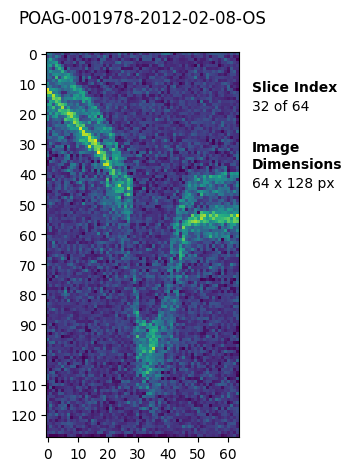

In [20]:
# view slice along axis 0 instead of axis 1
crossSection(npfile_index=0,axis_norm=0)

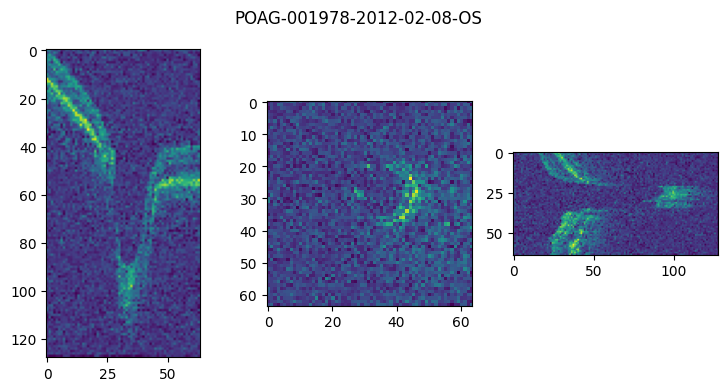

In [21]:
# VISUALIZING ALL OTHOGONAL MIDLINE SLICES IN ONE FIGURE

# Subset all orthogaonal midline slices; return_slice=True inside crossSection()
# returns the 2D array instead of rendering immediately
orthomids = [ crossSection(0,i,return_slice=True) for i in range(3) ]

# Calculate figure height & width based on the combined 
# slice dimensions when lined up horizontally
fH = np.array([ m.shape[0] for m in orthomids]).max().astype(int)
fW = np.array([ m.shape[1] for m in orthomids]).mean().astype(int)
fH,fW = round(fH/fW,1).as_integer_ratio()
fH,fW = fH*3,fW*2

# Set up figure and render each of the three orthogonal midline slices
fig,ax = plt.subplots(1,3,figsize=(fH,fW))
fig.suptitle(f'{npfilenames[0].strip('.npy')}')
for i,cxs in enumerate(orthomids):
    ax[i].imshow(cxs)

So it looks like slices along Axis 1 are definitely like circumpapillary scans ("coronal" sections), between slices along Axis 0 and 2, one represents a horizontal scan ("transverse" section) and one represents a vertical scan ("sagittal" section).  Based on the anatomy of how eyes are positioned out the the sides relative to where the optic nerves exit the cranial vault near midline, there is generally more asymmetry across the transverse (anatomical left-right) axis for a given eye than across the vertical axis (anatomical superior-inferior)&mdash;that would suggest the leftward image (slice along axis 0) is a "horizontal scan", while rightward image (slice along axis 2) is a "vertical scan".

That said, how the graphical horizontal & vertical axes (i.e., the ones of the 2D plot / rendered image, not the patient's anatomical axes) of the left and right images correpond to those of the middle image still needs to be defined.  This may be elucidated through looking at other slice positions along the axes (i.e., not midline) and correlating visual features between the orthogonal slices, for which creating a function to display the orthoplanes/slices at various slice depths may be helpful:

In [23]:
def orthoPlanes(file_index=0,ortho_depth=(.5,.5,.5)):

    # Simply copy the float across three axes
    if isinstance(ortho_depth,float):
        ortho_depth = (ortho_depth,ortho_depth,ortho_depth)
    # Otherwise, make sure it's an iterable with 1-3 items that's not a string
    
    elif not isinstance(ortho_depth,str)\
    and len(ortho_depth) in range(1,4):
        try:
            iter(ortho_depth)
            # Then replace the defaults from left to right / leave behind what's not specified.
            rem = 3 - len(ortho_depth)
            if rem > 0:
                odls = list(ortho_depth)
                for i in range(rem):
                    odls.append(0.5)
                ortho_depth = tuple(odls)
            else:
                pass           
            
        except:
            raise TypeError('ortho_depth must either be [1] a float or [2] a non-string iterable with 1-3 items')

    voldims = np.load(npfpaths[file_index]).shape
    
    orthoslices = [ crossSection(npfile_index=file_index, 
                                 return_slice=True,
                                 slice_depth=ortho_depth[axis],
                                 axis_norm=axis) for axis in range(3) ]
    
    fH = np.array([ m.shape[0] for m in orthoslices]).max().astype(int)
    fW = np.array([ m.shape[1] for m in orthoslices]).mean().astype(int)
    
    fH,fW = round(fH/fW,1).as_integer_ratio()
    fH,fW = fH*3,fW*3
    
    fig,ax = plt.subplots(1,3,figsize=(fH,fW))
    
    fig.suptitle(f'{npfilenames[file_index].strip('.npy')}')
    
    for i,cxs in enumerate(orthoslices):
        vertax,horizax = [ a for a in range(3) if a != i ]
        h,w = orthoslices[i].shape
        hh,ww = voldims[vertax],voldims[horizax]
        d = voldims[i]
        # print(hh,ww,d,'\n')
        slice_index = int(ortho_depth[i]*d)
        ax[i].imshow(cxs)
        ax[i].set_title(f'Axis {i}\n')
        ax[i].text(.5,1.02,f'Slice #{slice_index} of {d}', transform=ax[i].transAxes, 
                   fontsize=9, fontweight=None,
                  horizontalalignment='center')


        ax[i].set_xticks(range(0,w,15))
        ax[i].tick_params(axis='x',labelsize=7)
        ax[i].set_yticks(range(0,h,15))
        ax[i].tick_params(axis='y',labelsize=7)
        
        if i == 0:
            d1 = ortho_depth[1]*voldims[1]
            ax[i].axhline(d1,c='white')
        if i == 2:
            d1 = ortho_depth[1]*voldims[1]
            ax[i].axvline(d1,c='white')
        if i == 1:
            d02 = 0.5 * voldims[0]
            ax[i].axvline(d02,c='yellow')
            ax[i].axhline(d02,c='yellow')

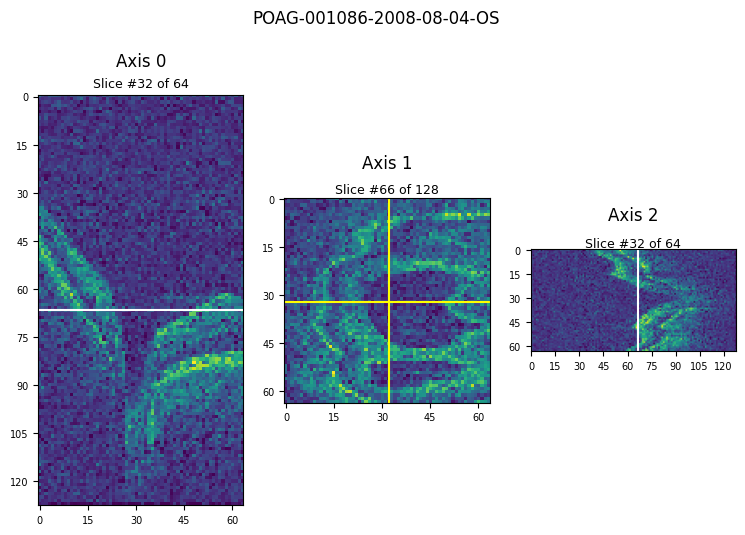

In [24]:
# Visualize the same orthoplanes, but advance the slice along axis 1 a bit (52% instead of 50% from 0 to 128px).
orthoPlanes(2,(.5,.52,.5))

The above shows white lines where the middle image cuts though the other images at slice 66 out of 128 along Axis 1.  Meanwhile, the yellow lines depict where the right and left image cut through the middle one, both of which are midway.

It is clearer now that the left image is the slice corresponding to the horizontal line in the middle image, as going from left to right across the left image at the white level should cross a single large dark spot slightly off center.  Meanwhile, the right-side image crosses through two dark spots along the white line - one centered and one to the periphery; this aligns well with what the vertical yellow line crosses through in the middle image. 

Therefore, 

+ The **horizontal axis** of the LEFT image corresponds the same axis of the MIDDLE image
+ The **vertical axis** of the RIGHT image corresponds to the same axis of the MIDDLE image

The `orhtoPlanes` function can be further modified, including colors of the axial lines, to reflect this:

In [25]:
def orthoPlanes(file_index=0,ortho_depth=(.5,.5,.5),axlines=False):

    # Simply copy the float across three axes
    if isinstance(ortho_depth,float):
        ortho_depth = (ortho_depth,ortho_depth,ortho_depth)
    # Otherwise, make sure it's an iterable with 1-3 items that's not a string
    
    elif not isinstance(ortho_depth,str)\
    and len(ortho_depth) in range(1,4):
        try:
            iter(ortho_depth)
            # Then replace the defaults from left to right / leave behind what's not specified.
            rem = 3 - len(ortho_depth)
            if rem > 0:
                odls = list(ortho_depth)
                for i in range(rem):
                    odls.append(0.5)
                ortho_depth = tuple(odls)
            else:
                pass           
            
        except:
            raise TypeError('ortho_depth must either be [1] a float or [2] a non-string iterable with 1-3 items')

    voldims = np.load(npfpaths[file_index]).shape
    
    orthoslices = [ crossSection(npfile_index=file_index, 
                                 return_slice=True,
                                 slice_depth=ortho_depth[axis],
                                 axis_norm=axis) for axis in range(3) ]
    
    fH = np.array([ m.shape[0] for m in orthoslices]).max().astype(int)
    fW = np.array([ m.shape[1] for m in orthoslices]).mean().astype(int)
    
    fH,fW = round(fH/fW,1).as_integer_ratio()
    fH,fW = fH*3,fW*3
    
    fig,ax = plt.subplots(1,3,figsize=(fH,fW))
    
    fig.suptitle(f'{npfilenames[file_index].strip('.npy')}')

    fig.set_facecolor('gray')

    cmap = {0:'red',1:'magenta',2:'yellow'}
    
    for i,cxs in enumerate(orthoslices):
        vertax,horizax = [ a for a in range(3) if a != i ]
        h,w = orthoslices[i].shape
        hh,ww = voldims[vertax],voldims[horizax]
        d = voldims[i]
        # print(hh,ww,d,'\n')
        slice_index = int(ortho_depth[i]*d)
        ax[i].imshow(cxs)
        ax[i].set_title(f'Axis {i}\n',c=cmap[i],fontweight='bold')
        ax[i].text(.5,1.02,f'Slice #{slice_index} of {d}', transform=ax[i].transAxes, 
                   fontsize=9, fontweight=None,
                  horizontalalignment='center')

        
        ax[i].set_xticks(range(0,w,15))
        ax[i].tick_params(axis='x',labelsize=7)
        ax[i].set_yticks(range(0,h,15))
        ax[i].tick_params(axis='y',labelsize=7)

        if axlines:
            alpha=0.75; ls='--'; lw=1.75
            
            if i == 0:
                dy = ortho_depth[1]*voldims[1]
                ax[i].axhline(dy,c=cmap[1],linewidth=lw,alpha=alpha,linestyle=ls)
    
                dx = ortho_depth[2]*voldims[2]
                ax[i].axvline(dx,c=cmap[2],linewidth=lw,alpha=alpha,linestyle=ls)
                
            if i == 2:
                dx = ortho_depth[1]*voldims[1]
                ax[i].axvline(dx,c=cmap[1],linewidth=lw,alpha=alpha,linestyle=ls)
                
                dy = ortho_depth[0] * voldims[0]
                ax[i].axhline(dy,c=cmap[0],linewidth=lw,alpha=alpha,linestyle=ls)
                
            if i == 1:
                dx = ortho_depth[2] * voldims[2]
                ax[i].axvline(dx,c=cmap[2],linewidth=lw,alpha=alpha,linestyle=ls)
                
                dy = ortho_depth[0] * voldims[0]
                ax[i].axhline(dy,c=cmap[0],linewidth=lw,alpha=alpha,linestyle=ls)

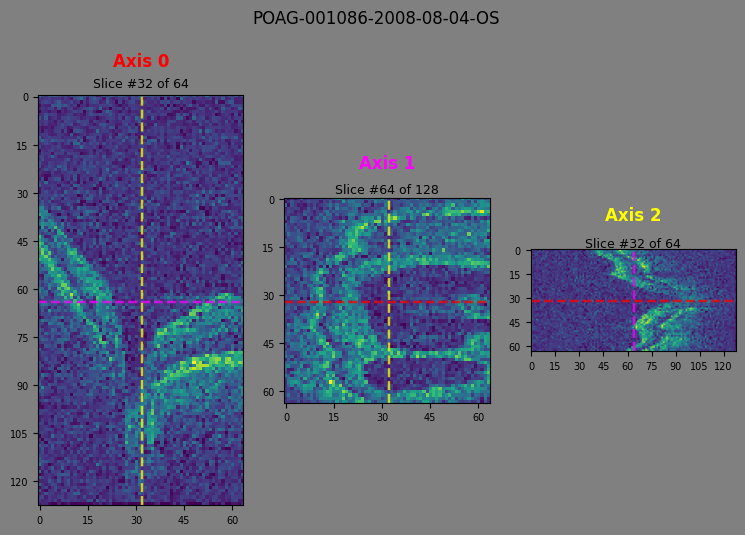

In [28]:
# axial-line-labeled orthoplanes with all default midline slices 
orthoPlanes(2, axlines=True)

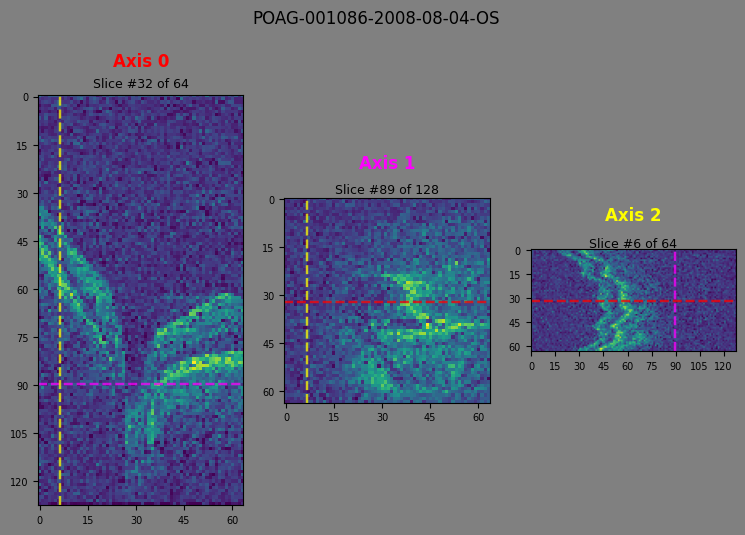

In [29]:
# Same volume, but slice depth shifted for some axes
orthoPlanes(2,(.5,.7,.1), axlines=True)

##### Further Function Mods 

In [ ]:
def orthoPlanes(file_index=0,ortho_depth=(.5,.5,.5),axlines=False,anatomy_axes=False):

    # Simply copy the float across three axes
    if isinstance(ortho_depth,float):
        ortho_depth = (ortho_depth,ortho_depth,ortho_depth)
    # Otherwise, make sure it's an iterable with 1-3 items that's not a string
    
    elif not isinstance(ortho_depth,str)\
    and len(ortho_depth) in range(1,4):
        try:
            iter(ortho_depth)
            # Then replace the defaults from left to right / leave behind what's not specified.
            rem = 3 - len(ortho_depth)
            if rem > 0:
                odls = list(ortho_depth)
                for i in range(rem):
                    odls.append(0.5)
                ortho_depth = tuple(odls)
            else:
                pass           
            
        except:
            raise TypeError('ortho_depth must either be [1] a float or [2] a non-string iterable with 1-3 items')

    voldims = np.load(npfpaths[file_index]).shape
    
    orthoslices = [ crossSection(npfile_index=file_index, 
                                 return_slice=True,
                                 slice_depth=ortho_depth[axis],
                                 axis_norm=axis) for axis in range(3) ]
    
    fH = np.array([ m.shape[0] for m in orthoslices]).max().astype(int)
    fW = np.array([ m.shape[1] for m in orthoslices]).mean().astype(int)
    
    fH,fW = round(fH/fW,1).as_integer_ratio()
    fH,fW = fH*3,fW*3
    
    fig,ax = plt.subplots(1,3,figsize=(fH,fW))
    
    fig.suptitle(f'{npfilenames[file_index].strip('.npy')}')

    fig.set_facecolor('gray')

    cmap = {0:'red',1:'magenta',2:'yellow'}
    
    for i,cxs in enumerate(orthoslices):
        vertax,horizax = [ a for a in range(3) if a != i ]
        h,w = orthoslices[i].shape
        hh,ww = voldims[vertax],voldims[horizax]
        d = voldims[i]
        # print(hh,ww,d,'\n')
        slice_index = int(ortho_depth[i]*d)
        ax[i].imshow(cxs)
        ax[i].set_title(f'Axis {i}\n',c=cmap[i],fontweight='bold')
        ax[i].text(.5,1.02,f'Slice #{slice_index} of {d}', transform=ax[i].transAxes, 
                   fontsize=9, fontweight=None,
                  horizontalalignment='center')

        
        ax[i].set_xticks(range(0,w,15))
        ax[i].tick_params(axis='x',labelsize=7)
        ax[i].set_yticks(range(0,h,15))
        ax[i].tick_params(axis='y',labelsize=7)

        if axlines:
            alpha=0.75; ls='--'; lw=1.75
            
            if i == 0:
                dy = ortho_depth[1]*voldims[1]
                ax[i].axhline(dy,c=cmap[1],linewidth=lw,alpha=alpha,linestyle=ls)
    
                dx = ortho_depth[2]*voldims[2]
                ax[i].axvline(dx,c=cmap[2],linewidth=lw,alpha=alpha,linestyle=ls)

                if anatomy_axes:
                    ax[i].annotate('', xy=(60, 0), xytext=(60, 35),
                               transform=ax[i].transAxes, 
                               arrowprops=dict(arrowstyle='->', 
                                               color='white',
                                              mutation_scale=20,
                                              linewidth=3))
                    ax[i].text(55, 15, 'anterior', 
                               horizontalalignment='right', 
                               verticalalignment='center', 
                               color='white',
                               fontweight='bold',
                               rotation=90)
                
                
            if i == 2:
                dx = ortho_depth[1]*voldims[1]
                ax[i].axvline(dx,c=cmap[1],linewidth=lw,alpha=alpha,linestyle=ls)
                
                dy = ortho_depth[0] * voldims[0]
                ax[i].axhline(dy,c=cmap[0],linewidth=lw,alpha=alpha,linestyle=ls)

                if anatomy_axes:
                    #AXIS 2 ANTERIOR ARROW
                    ax[i].annotate('', xy=(0, 15), xytext=(35, 15),
                                   transform=ax[i].transAxes, 
                                   arrowprops=dict(arrowstyle='->', 
                                                   color='white',
                                                  mutation_scale=10,
                                                  linewidth=2))
                    ax[i].text(45, 6, 'anterior', 
                               horizontalalignment='right', 
                               verticalalignment='center', 
                               color='white',
                               fontweight='bold',
                               rotation=0)
                
            if i == 1:
                dx = ortho_depth[2] * voldims[2]
                ax[i].axvline(dx,c=cmap[2],linewidth=lw,alpha=alpha,linestyle=ls)
                
                dy = ortho_depth[0] * voldims[0]
                ax[i].axhline(dy,c=cmap[0],linewidth=lw,alpha=alpha,linestyle=ls)

orthoPlanes(1,(.5,.7,.1), axlines=True, anatomy_axes=True)

##### Volume Data Summary

Some things are clearly true here. 

+ **Axis 1** is the longest axis at 128px, pertaining to retinal depth (slice index 127 is all the way at the back of the eye, while index 0 is the most superfical/anterior).
+ **Axis 0** and **Axis 2** are both 64px
    + **Axis 0** corresponds to the y-axis of the Axis 1 slice; as you advance through slice indices from 0 to 63, you move the red line from top to bottom on the y-axis of the square image.
    + **Axis 2** corresponds to the x-axis of the Axis 1 slice; as you advance through slice indices along Axis 2, you move the yellow line in the square image from left to right on the x-axis.

<div class="alert alert-warning alert-dismissible fade show" style="color:magenta">
        <strong>***While anteior-posterior axes are quite obvious, determining which of the remaining axes are superior-inferior vs. left-right may be challenging; based on the ways the optic nerve must bend medially relative to the orbit, the asymmetry of most of the Axis 0 images relative to Axis 2 suggests the horizontal axis of of the Axis 0 might represent left-right, i.e. 0-->64 is left to right and for OD that means medial to lateral while for OS that measn lateral to medial...  </strong>
</div>
</div>

### Extracting Tabular Data from Filenames

As touched on earlier, the filenames for these volumes are encoded with some basic features that could be extracted into a tabular format. 

In [31]:
npfilenames[64]

'Normal-003102-2009-09-03-OS.npy'

In [32]:
# Establish names for basic components to of the filename to split
vcols = "dx_class patient_id date laterality filename".split(' ')

# Initialize lists for each feature
dxs = []; pids = []; dates = []; lats = []

# Iterate through all filenames, extracting out the feature values and appending to lists
for name in npfilenames:   
    dx, pid, yr, mo, d, lat = name.strip('.npy').split('-')

    # combine the date elements (year,month,day) into a single datetime object
    dtstring = '-'.join([yr,mo,d])
    dt = datetime.strptime(dtstring,'%Y-%m-%d')
    
    dates.append(dt)
    dxs.append(dx)
    pids.append(pid)
    lats.append(lat)

# Combine resulting feature lists into a sample/data array, and transpose (for pandas format)
tbldata = np.array([ dxs, pids, dates, lats, npfilenames ]).T

# Convert to DataFrame
voluMetadata = pd.DataFrame(tbldata,columns=vcols)
voluMetadata.head()

,dx_class,patient_id,date,laterality,filename
0,POAG,001978,2012-02-08,OS,POAG-001978-2012-02-08-OS.npy
1,Normal,002743,2009-03-26,OS,Normal-002743-2009-03-26-OS.npy
2,POAG,001086,2008-08-04,OS,POAG-001086-2008-08-04-OS.npy
3,POAG,000092,2010-12-14,OS,POAG-000092-2010-12-14-OS.npy
4,POAG,003223,2014-01-10,OD,POAG-003223-2014-01-10-OD.npy


In [33]:
voluMetadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dx_class    1110 non-null   object        
 1   patient_id  1110 non-null   object        
 2   date        1110 non-null   datetime64[ns]
 3   laterality  1110 non-null   object        
 4   filename    1110 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 43.5+ KB


In [34]:
voluMetadata.describe(datetime_is_numeric=True)

,date
count,1110
mean,2010-08-10 15:49:37.297297152
min,2007-10-19 00:00:00
25%,2008-11-26 12:00:00
50%,2009-11-09 12:00:00
75%,2011-11-19 12:00:00
max,2016-11-30 00:00:00


This is essentially the tabular portion of the data, to be used as a reference later on.  Particularly, in Phase 1 with the unimodal CNN approach, we can make use of the `dx_class` labels for training and for testing performance (i.e., after splitting into test-train sets).  

<u>Info on Features/Categories</u>

+ Diagnostic Class:
    + **POAG** = **Primary Open-Angle Glaucoma**
    + Normal
+ Laterality:
    +  **OS** (*Oculus sinister*) = left eye
    +  **OD** (*Oculus dexter*) = right eye

Of note, since most patient_id's will be associated with 2 entries (some with only 1, for various potential reasons<sup>&dagger;</sup>) there will potentialy be some correlation between the eyes.

<sup>&dagger;</sup>For example, the other eye was enucleated/removed (e.g., d/t hx of advanced glaucoma in that eye or some comorbidity), or the OCT scan was simply missing for whatever reason.

In [35]:
bilvsuni_ptcounts = voluMetadata.value_counts('patient_id').value_counts()
bilvsuni_ptcounts

2    486
1    138
dtype: int64

In [36]:
n_patients = voluMetadata.value_counts('patient_id').value_counts().sum()
n_patients

624

So despite the 1110 total images, the dataset represents 624 patients, 486 of which include scans of both eyes, and 138 having only one scan.

In [37]:
bilpids = voluMetadata.value_counts('patient_id')[voluMetadata.value_counts('patient_id') == 2].index #patient_id's in which there are two scans

voluMetadata['bil_scan'] = voluMetadata['patient_id'].isin(bilpids) #create boolean column for whether or not it was bilateral scan (both eyes scanned)

voluMetadata.head()

,dx_class,patient_id,date,laterality,filename,bil_scan
0,POAG,001978,2012-02-08,OS,POAG-001978-2012-02-08-OS.npy,False
1,Normal,002743,2009-03-26,OS,Normal-002743-2009-03-26-OS.npy,True
2,POAG,001086,2008-08-04,OS,POAG-001086-2008-08-04-OS.npy,True
3,POAG,000092,2010-12-14,OS,POAG-000092-2010-12-14-OS.npy,True
4,POAG,003223,2014-01-10,OD,POAG-003223-2014-01-10-OD.npy,True


In [38]:
voluMetadata.value_counts('bil_scan')

bil_scan
True     972
False    138
dtype: int64

As expected, the number of single eye scans that were part of bilateral scans (972) is twice the number of patients who had bilateral scans done (486).  Meanwhile, the same 138 patients with only one eye scanned correspond with the 138 unilateral eye scans. 

In [39]:
# of all images that were part of bilateral scans
# group them with the other image for the same patient -i.e., by patient_id
# get number of unique diagnostic labels for each patient - i.e., 2 if only unilateral glaucoma
voluMetadata[voluMetadata.bil_scan].\
    groupby('patient_id')\
    ['dx_class'].nunique()\
    .value_counts() # count how many patients fall under bilateral (normal or glaucoma) vs. unilateral glaucoma


1    486
Name: dx_class, dtype: int64

This shows that all patients in the dataset that had bilateral scans either had bilateral normal eyes or bilateral glaucomatous eyes.

In [40]:
# Checking OCT scans occurred on same date for both eyes
voluMetadata[voluMetadata.bil_scan].groupby('patient_id')['laterality'].value_counts('date').value_counts()

0.5    972
Name: laterality, dtype: int64

While this shows all bilaterally scanned patients had both eyes scanned on the same date.

<div class="alert alert-warning alert-dismissible fade show" style="color:magenta">
        <strong>***</strong>
    Can it be assumed that the unilaterally scanned patients, if positive for glaucoma had bilateral disease and if negative had bilaterally normal eyes?  Does it matter?  Perhaps the data set could be split into `bil_scan=True` and `bil_scan=False`, to be compared in the next step with EDA. As we created the `bil_scan` column, this will be easy to subset if necessary.
</div></strong>
</div>


Additionally, while the bilateral scans are guaranteed to contribute a perfectly even distribution of OS and OD images, this is not necessarily the case for the unilateral scans - can check with:

In [41]:
# Of the unilateral scans, how do the distributions look for laterality of disease
voluMetadata[~voluMetadata.bil_scan].groupby('dx_class')['laterality'].value_counts('laterality')

dx_class  laterality
Normal    OD            0.545455
          OS            0.454545
POAG      OD            0.527559
          OS            0.472441
Name: laterality, dtype: float64

A fairly balanced split between OD/OS among both normal and glaucomatous.

In [42]:
voluMetadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dx_class    1110 non-null   object        
 1   patient_id  1110 non-null   object        
 2   date        1110 non-null   datetime64[ns]
 3   laterality  1110 non-null   object        
 4   filename    1110 non-null   object        
 5   bil_scan    1110 non-null   bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 44.6+ KB


At this point, not much need to change the Dtype of any column:

+ `dx_class` and `laterality` could also be converted to binary integers or boolean, but may be redundant depending on decisions down the line r.e. the modeling approach and pre-processing
+  `patient_id` is rightfully non-numeric, as we don't want to be performing any mathematical operations that could alter them as unique identifiers; sorting by this column will probably have no issues done lexically (rather than numeric sorting) as long as the number of digits are kept the same. 

In [43]:
# Save tabular data to csv
voluMetadata.to_csv('../datasrc/volumeOCT_metadata.csv',index=False)

That said, for the sake of convenient statistical summarizations:

In [44]:
# Hot-One Encoding, should this be needed later on...
nonbincols =['date','filename','patient_id']
henc = pd.get_dummies(voluMetadata.select_dtypes('object').iloc[:,:-1],drop_first=True)
henc = henc.rename(columns={'dx_class_POAG':'glaucoma','laterality_OS':'left_eye'})

vmdhenc = pd.concat([henc,voluMetadata[nonbincols]],axis=1)
vmdhenc = vmdhenc[['patient_id','glaucoma','left_eye','date','filename']]\
    .sort_values('patient_id')
vmdhenc.head()

,patient_id,glaucoma,left_eye,date,filename
813,000002,0,1,2009-10-28,Normal-000002-2009-10-28-OS.npy
826,000002,0,0,2009-10-28,Normal-000002-2009-10-28-OD.npy
53,000008,1,0,2009-02-03,POAG-000008-2009-02-03-OD.npy
426,000014,1,0,2009-11-30,POAG-000014-2009-11-30-OD.npy
747,000014,1,1,2009-11-30,POAG-000014-2009-11-30-OS.npy


In [45]:
vmdhenc.describe(datetime_is_numeric=True)

,glaucoma,left_eye,date
count,1110.000000,1110.000000,1110
mean,0.763063,0.496396,2010-08-10 15:49:37.297297152
min,0.000000,0.000000,2007-10-19 00:00:00
25%,1.000000,0.000000,2008-11-26 12:00:00
50%,1.000000,0.000000,2009-11-09 12:00:00
75%,1.000000,1.000000,2011-11-19 12:00:00
max,1.000000,1.000000,2016-11-30 00:00:00
std,0.425395,0.500212,NaN


In [46]:
bindist = pd.DataFrame(vmdhenc.select_dtypes('uint8').sum(),columns=['yes'])

bindist['no'] = len(vmdhenc) - bindist['yes']

bindist['yes%'] = round(bindist['yes']*100 / len(vmdhenc),2)
bindist['no%'] = round(bindist['no']*100 / len(vmdhenc),2)
bindist

,yes,no,yes%,no%
glaucoma,847,263,76.31,23.69
left_eye,551,559,49.64,50.36


## Set 2 | Composite Fundus & OCT Images (2D) 

In [58]:
# Within focPATH, get all paths that lead to *.* (i.e., a file, in most cases)
focFilepaths = glob.glob(os.path.join(focPATH,'**','*.*'),recursive=True)

# Ensure all of these files are are images
focImgPaths = [ fp for fp in focFilepaths if magic.from_file(fp,mime=True).startswith('image') ]

# Preview a few image paths
focImgPaths[10:20]

['../datasrc/fundus-oct-composite/Glaucoma/P_6/Right Eye/Fundus_Right_Glaucoma_Cup.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Right Eye/1910153_20151019_102803_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Right Eye/OCT_Right_Glaucoma_Cup.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Right Eye/1910153_20151019_102803_Color_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Right Eye/Fundus_Right_Glaucoma_Disc.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Right Eye/OCT_Right_Glaucoma_Disc.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Left Eye/1910153_20151019_102937_B-scan_L_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Left Eye/1910153_20151019_102937_Color_L_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Left Eye/1910153_20151019_102937_Red-free_L_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Left Eye/Fundus_Left_Glaucoma_Cup.jpg']

In [60]:
# Check if all paths descend an equal number of levels
unique_depths = list(set([ len(ip.split('/')) for ip in focImgPaths ]))
len(unique_depths)

1

In [66]:
# Cut out the first part
subpaths = [ ip.split(focPATH+'/')[-1] for ip in focImgPaths ]
mid = int(len(subpaths)/2)
print(len(subpaths))
subpaths[mid:mid+15]

417


['Glaucoma/P_3/Right Eye/Fundus_Right_Glaucoma_Disc.jpg',
 'Glaucoma/P_3/Right Eye/109159_20150910_095053_B-scan_R_001.jpg',
 'Glaucoma/P_3/Right Eye/OCT_Right_Glaucoma_Disc.jpg',
 'Glaucoma/P_3/Left Eye/109159_20150910_095213_B-scan_L_001.jpg',
 'Glaucoma/P_3/Left Eye/109159_20150910_095213_Red-free_L_001.jpg',
 'Glaucoma/P_3/Left Eye/Fundus_Left_Glaucoma_Cup.jpg',
 'Glaucoma/P_3/Left Eye/109159_20150910_095213_Color_L_001.jpg',
 'Glaucoma/P_3/Left Eye/OCT_Left_Glaucoma_Disc.jpg',
 'Glaucoma/P_3/Left Eye/Fundus_Left_Glaucoma_Disc.jpg',
 'Glaucoma/P_3/Left Eye/OCT_Left_Glaucoma_Cup.jpg',
 'Glaucoma/P_10/Right Eye/1691587_20150916_103043_Color_R_001.jpg',
 'Glaucoma/P_10/Right Eye/1691587_20150916_103043_Red-free_R_001.jpg',
 'Glaucoma/P_10/Right Eye/Fundus_Right_Glaucoma_Cup.jpg',
 'Glaucoma/P_10/Right Eye/OCT_Right_Glaucoma_Cup.jpg',
 'Glaucoma/P_10/Right Eye/1691587_20150916_103043_B-scan_R_001.jpg']

In [67]:
OCTsubpaths = [ sp for sp in subpaths if 'Fundus' not in sp ]
print(len(OCTsubpaths))
OCTsubpaths[mid-20:mid]

328


['Glaucoma/P_13/Right Eye/149155_20150914_095855_Red-free_R_001.jpg',
 'Glaucoma/P_13/Right Eye/OCT_Right_Glaucoma_Cup.jpg',
 'Glaucoma/P_13/Right Eye/OCT_Right_Glaucoma_Disc.jpg',
 'Glaucoma/P_13/Left Eye/149155_20150914_100517_Red-free_L_001.jpg',
 'Glaucoma/P_13/Left Eye/149155_20150914_100517_Color_L_001.jpg',
 'Glaucoma/P_13/Left Eye/149155_20150914_100517_B-scan_L_001.jpg',
 'Glaucoma/P_13/Left Eye/OCT_Left_Glaucoma_Disc.jpg',
 'Glaucoma/P_13/Left Eye/OCT_Left_Glaucoma_Cup.jpg',
 'Healthy/P_16/Right Eye/09091426_20140909_180001_Color_R_001.jpg',
 'Healthy/P_16/Right Eye/09091426_20140909_180001_Red-free_R_001.jpg',
 'Healthy/P_16/Right Eye/09091426_20140909_180001_B-scan_R_001.jpg',
 'Healthy/P_16/Left Eye/09091426_20140909_180041_Red-free_L_001.jpg',
 'Healthy/P_16/Left Eye/09091426_20140909_180041_Color_L_001.jpg',
 'Healthy/P_16/Left Eye/09091426_20140909_180041_B-scan_L_001.jpg',
 'Healthy/P_6/Right Eye/261015_20151026_112409_Red-free_R_001.jpg',
 'Healthy/P_6/Right Eye/OCT_R

In [134]:
scan_types = ['Red-free',
              'Color',
              'B-scan',
              'Disc',
              'Cup']

In [79]:
typereps = []
for st in scan_types:
    tr = [ sp for sp in OCTsubpaths if st in sp ][0]
    typereps.append(tr)

typereps

['Glaucoma/P_26/Right Eye/99144_20140909_173003_Red-free_R_001.jpg',
 'Glaucoma/P_26/Right Eye/99144_20140909_173003_Color_R_001.jpg',
 'Glaucoma/P_26/Right Eye/99144_20140909_173003_B-scan_R_001.jpg',
 'Glaucoma/P_6/Right Eye/OCT_Right_Glaucoma_Disc.jpg',
 'Glaucoma/P_6/Right Eye/OCT_Right_Glaucoma_Cup.jpg']

In [120]:
trpaths = [os.path.join(focPATH,tr) for tr in typereps]

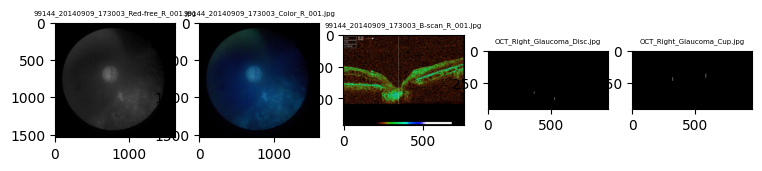

In [122]:
def viewFOC(imgpath,grayscale=False):
    if isinstance(imgpath,(list,tuple)):
        nsp = len(imgpath)
        fig,ax = plt.subplots(1,nsp,figsize=(9,3))

        for i in range(len(imgpath)):
            imgarr = cv2.imread(imgpath[i])
            if grayscale:
                imgarr = cv2.cvtColor(imgarr,cv2.COLOR_RGB2GRAY)
            ax[i].imshow(imgarr)
            ax[i].set_title(f'{os.path.basename(imgpath[i])}',fontsize=5)
            
    elif isinstance(imgpath,str):
        imgarr = cv2.imread(imgpath)
        if grayscale:
            imgarr = cv2.cvtColor(imgarr,cv2.COLOR_RGB2GRAY)
        plt.imshow(imgarr)
        plt.title(f'{os.path.basename(imgpath)}')
        
    
viewFOC(trpaths[:])

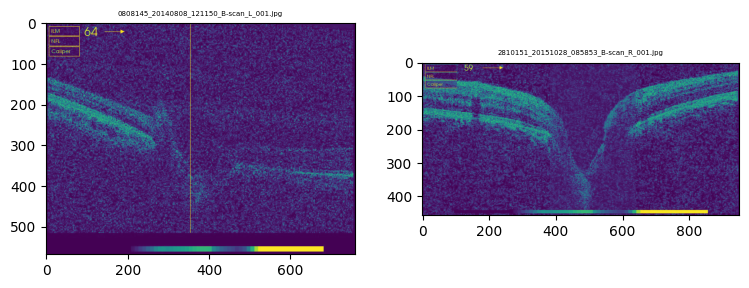

In [109]:
bscans = [ os.path.join(focPATH,sp) for sp in OCTsubpaths if 'B-scan' in sp ]

viewFOC(bscans[10:12],grayscale=True)

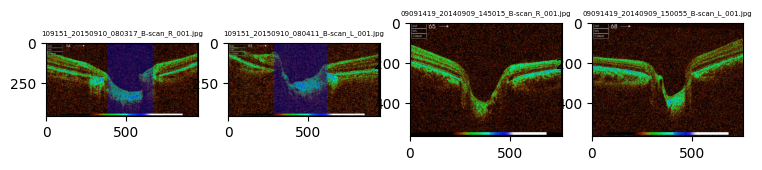

In [110]:
viewFOC(bscans[15:19])

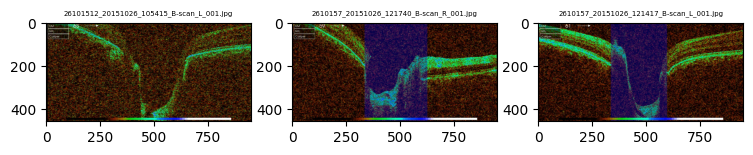

In [111]:
viewFOC(bscans[56:59])

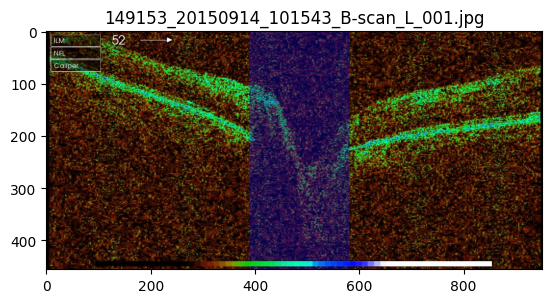

In [131]:
viewFOC(bscans[14],grayscale=None)

<div class="alert alert-warning alert-dismissible fade show" style="color:magenta">
    
It appears only the B-Scan images match up to anything seen in the volumetric data, but the corresponding slice of that data seems to fit within shaded central regions of these images since the volumetric data were optic nerve head centered.  It may be possible to join this dataset with the volumetric if:

+ cropped to the same aspect-ratio of volumetric slices (2:1 or 1:2) based on provided bounding box/label
+ downsampled to match the same 64 x 128 or 128 x 64 px resolution
+ converted to grayscale (these have color channels)

Meanwhile the volumetric ones must be subset to only the slice that corresponds to these b-scans.

However, all of this might need to be saved for EDA and pre-processing. For now, it is sufficient to identify the correct data points / drop the others, which we did.  For the potential utility in providing crop margins, the "Disc" and "Cup" may be worth keeping as well.  But this essentially changes the scope to focus on horizontal B-Scans only rather than whole volumes or orthogonal slices for the unimodal phase of the project; which would be interesting in and of itself&mdash;can simply focusing on such scans provide at least close performance?

</div>

In [130]:
len(bscans)

80

And this essentially just adds 80 images to the volumetric dataset.

In [137]:
if 'Red-free' in scan_types:
    scan_types.remove('Red-free')
if 'Color' in scan_types:
    scan_types.remove('Color')
scan_types

['B-scan', 'Disc', 'Cup']

In [139]:
OCTipaths = []
OCTimgSPs = []

for t in scan_types:
    for sp in OCTsubpaths:
        if t in sp:
            imgPath = os.path.join(focPATH,sp)
            OCTipaths.append(imgPath)
            OCTimgSPs.append(sp)

In [140]:
focb = pd.DataFrame({'path':OCTimgSPs})
focb = focb['path'].str.split('/',expand=True)
focb.columns = ['dx_class','pid','laterality','filename']
focb.head()

,dx_class,pid,laterality,filename
0,Glaucoma,P_26,Right Eye,99144_20140909_173003_B-scan_R_001.jpg
1,Glaucoma,P_26,Left Eye,99144_20140909_173131_B-scan_L_001.jpg
2,Glaucoma,P_16,Left Eye,09091428_20140909_183107_B-scan_L_001.jpg
3,Glaucoma,P_6,Right Eye,1910153_20151019_102803_B-scan_R_001.jpg
4,Glaucoma,P_6,Left Eye,1910153_20151019_102937_B-scan_L_001.jpg


In [141]:
focb['laterality'] = focb['laterality'].apply(lambda l : "OS" if l.startswith('L') else 'OD')
focb['laterality'].head()

0    OD
1    OS
2    OS
3    OD
4    OS
Name: laterality, dtype: object

In [145]:
focb['dx_class'] = focb['dx_class'].apply(lambda d : "Normal" if d.startswith('H') else d)
focb['dx_class'].unique()

array(['Glaucoma', 'Normal'], dtype=object)

In [148]:
focb.head()

,dx_class,pid,laterality,filename
0,Glaucoma,P_26,OD,99144_20140909_173003_B-scan_R_001.jpg
1,Glaucoma,P_26,OS,99144_20140909_173131_B-scan_L_001.jpg
2,Glaucoma,P_16,OS,09091428_20140909_183107_B-scan_L_001.jpg
3,Glaucoma,P_6,OD,1910153_20151019_102803_B-scan_R_001.jpg
4,Glaucoma,P_6,OS,1910153_20151019_102937_B-scan_L_001.jpg


In [161]:
focb.value_counts('pid')

pid
P_9     12
P_8     12
P_6     12
P_5     12
P_4     12
P_3     12
P_2     10
P_10    10
P_7      9
P_1      9
P_11     9
P_12     8
P_14     7
P_13     7
P_18     4
P_17     3
P_16     3
P_15     3
P_19     2
P_20     2
P_22     2
P_23     2
P_24     2
P_25     2
P_26     2
P_21     2
dtype: int64

In [162]:
focb[focb['pid'] == 'P_9']

,dx_class,pid,laterality,filename
29,Glaucoma,P_9,OD,9915999_20150909_140154_B-scan_R_001.jpg
30,Glaucoma,P_9,OS,9915999_20150909_140029_B-scan_L_001.jpg
67,Normal,P_9,OD,149159898_20150914_122637_B-scan_R_001.jpg
68,Normal,P_9,OS,149159898_20150914_122713_B-scan_L_001.jpg
91,Glaucoma,P_9,OD,OCT_Right_Glaucoma_Disc.jpg
92,Glaucoma,P_9,OS,OCT_Left_Glaucoma_Disc.jpg
117,Normal,P_9,OD,OCT_Right_Normal_Disc.jpg
118,Normal,P_9,OS,OCT_Left_Normal_Disc.jpg
136,Glaucoma,P_9,OD,OCT_Right_Glaucoma_Cup.jpg
137,Glaucoma,P_9,OS,OCT_Left_Glaucoma_Cup.jpg


In [163]:
focb[focb['pid'] == 'P_3']

,dx_class,pid,laterality,filename
43,Glaucoma,P_3,OD,109159_20150910_095053_B-scan_R_001.jpg
44,Glaucoma,P_3,OS,109159_20150910_095213_B-scan_L_001.jpg
75,Normal,P_3,OD,1491511221_20150914_123434_B-scan_R_001.jpg
76,Normal,P_3,OS,1491511221_20150914_123523_B-scan_L_001.jpg
99,Glaucoma,P_3,OD,OCT_Right_Glaucoma_Disc.jpg
100,Glaucoma,P_3,OS,OCT_Left_Glaucoma_Disc.jpg
122,Normal,P_3,OD,OCT_Right_Normal_Disc.jpg
123,Normal,P_3,OS,OCT_Left_Normal_Disc.jpg
144,Glaucoma,P_3,OD,OCT_Right_Glaucoma_Cup.jpg
145,Glaucoma,P_3,OS,OCT_Left_Glaucoma_Cup.jpg


In [164]:
focb[focb['pid'] == 'P_18']

,dx_class,pid,laterality,filename
31,Glaucoma,P_18,OD,1091413_20140910_151948_B-scan_R_001.jpg
32,Glaucoma,P_18,OS,1091413_20140910_152037_B-scan_L_001.jpg
69,Normal,P_18,OD,0909148_20140909_115937_B-scan_R_001.jpg
70,Normal,P_18,OS,0909148_20140909_120043_B-scan_L_001.jpg


In [165]:
focb[focb['pid'] == 'P_17']

,dx_class,pid,laterality,filename
19,Glaucoma,P_17,OD,09091422_20140909_152236_B-scan_R_001.jpg
20,Glaucoma,P_17,OS,09091422_20140909_151823_B-scan_L_001.jpg
65,Normal,P_17,OS,99144_20140909_173131_B-scan_L_001.jpg


In [160]:
focb.groupby('pid')['laterality'].value_counts('laterality')

pid   laterality
P_1   OS            0.666667
      OD            0.333333
P_10  OS            0.600000
      OD            0.400000
P_11  OD            0.666667
      OS            0.333333
P_12  OD            0.500000
      OS            0.500000
P_13  OS            0.571429
      OD            0.428571
P_14  OD            0.571429
      OS            0.428571
P_15  OD            0.666667
      OS            0.333333
P_16  OS            0.666667
      OD            0.333333
P_17  OS            0.666667
      OD            0.333333
P_18  OD            0.500000
      OS            0.500000
P_19  OD            0.500000
      OS            0.500000
P_2   OD            0.700000
      OS            0.300000
P_20  OD            0.500000
      OS            0.500000
P_21  OD            0.500000
      OS            0.500000
P_22  OD            0.500000
      OS            0.500000
P_23  OD            0.500000
      OS            0.500000
P_24  OD            0.500000
      OS            0.5000

In [166]:
focb[focb['pid'] == 'P_21']

,dx_class,pid,laterality,filename
23,Glaucoma,P_21,OD,0809142_20140908_103321_B-scan_R_001.jpg
24,Glaucoma,P_21,OS,0809142_20140908_103145_B-scan_L_001.jpg


In [ ]:
dualpids = voluMetadata.value_counts('patient_id')[voluMetadata.value_counts('patient_id') == 2].index #patient_id's in which there are two scans

voluMetadata['bil_scan'] = voluMetadata['patient_id'].isin(bilpids) #create boolean column for whether or not it was bilateral scan (both eyes scanned)

voluMetadata.head()

In [149]:
focb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dx_class    170 non-null    object
 1   pid         170 non-null    object
 2   laterality  170 non-null    object
 3   filename    170 non-null    object
dtypes: object(4)
memory usage: 5.4+ KB


In [119]:
voluMetadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dx_class    1110 non-null   object        
 1   patient_id  1110 non-null   object        
 2   date        1110 non-null   datetime64[ns]
 3   laterality  1110 non-null   object        
 4   filename    1110 non-null   object        
 5   bil_scan    1110 non-null   bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 44.6+ KB


In [167]:
voluMetadata.drop('date',axis=1)

,dx_class,patient_id,laterality,filename,bil_scan
0,POAG,001978,OS,POAG-001978-2012-02-08-OS.npy,False
1,Normal,002743,OS,Normal-002743-2009-03-26-OS.npy,True
2,POAG,001086,OS,POAG-001086-2008-08-04-OS.npy,True
3,POAG,000092,OS,POAG-000092-2010-12-14-OS.npy,True
4,POAG,003223,OD,POAG-003223-2014-01-10-OD.npy,True
...,...,...,...,...,...
1105,POAG,002548,OS,POAG-002548-2008-07-22-OS.npy,True
1106,POAG,003292,OD,POAG-003292-2013-08-19-OD.npy,True
1107,POAG,000821,OD,POAG-000821-2008-02-25-OD.npy,True
1108,POAG,000275,OD,POAG-000275-2010-01-19-OD.npy,True


In [173]:
voluMeta = pd.DataFrame(voluMetadata.drop('date',axis=1))
voluMeta['dx_class'] = voluMeta['dx_class'].str.replace('POAG','Glaucoma')
voluMeta

,dx_class,patient_id,laterality,filename,bil_scan
0,Glaucoma,001978,OS,POAG-001978-2012-02-08-OS.npy,False
1,Normal,002743,OS,Normal-002743-2009-03-26-OS.npy,True
2,Glaucoma,001086,OS,POAG-001086-2008-08-04-OS.npy,True
3,Glaucoma,000092,OS,POAG-000092-2010-12-14-OS.npy,True
4,Glaucoma,003223,OD,POAG-003223-2014-01-10-OD.npy,True
...,...,...,...,...,...
1105,Glaucoma,002548,OS,POAG-002548-2008-07-22-OS.npy,True
1106,Glaucoma,003292,OD,POAG-003292-2013-08-19-OD.npy,True
1107,Glaucoma,000821,OD,POAG-000821-2008-02-25-OD.npy,True
1108,Glaucoma,000275,OD,POAG-000275-2010-01-19-OD.npy,True


In [176]:
focMeta = pd.DataFrame(focb)
focMeta['bil_scan'] = [ True for i in range(len(focMeta)) ]
focMeta = focMeta.rename(columns={'pid':'patient_id'})
focMeta

,dx_class,patient_id,laterality,filename,bil_scan
0,Glaucoma,P_26,OD,99144_20140909_173003_B-scan_R_001.jpg,True
1,Glaucoma,P_26,OS,99144_20140909_173131_B-scan_L_001.jpg,True
2,Glaucoma,P_16,OS,09091428_20140909_183107_B-scan_L_001.jpg,True
3,Glaucoma,P_6,OD,1910153_20151019_102803_B-scan_R_001.jpg,True
4,Glaucoma,P_6,OS,1910153_20151019_102937_B-scan_L_001.jpg,True
...,...,...,...,...,...
165,Normal,P_5,OS,OCT_Left_Normal_Cup.jpg,True
166,Normal,P_11,OD,OCT_Right_Normal_Cup.jpg,True
167,Normal,P_3,OD,OCT_Right_Normal_Cup.jpg,True
168,Normal,P_3,OS,OCT_Left_Normal_Cup.jpg,True


In [206]:
combodf = pd.concat([voluMeta,focMeta],axis=0)
combodf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1280 entries, 0 to 169
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dx_class    1280 non-null   object
 1   patient_id  1280 non-null   object
 2   laterality  1280 non-null   object
 3   filename    1280 non-null   object
 4   bil_scan    1280 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 51.2+ KB


In [208]:
combodf = combodf.reset_index().drop('index',axis=1)

In [209]:
combodf.describe()

,dx_class,patient_id,laterality,filename,bil_scan
count,1280,1280,1280,1280,1280
unique,2,650,2,1194,2
top,Glaucoma,P_6,OD,OCT_Right_Glaucoma_Cup.jpg,True
freq,946,12,646,13,1142


In [210]:
combodf

,dx_class,patient_id,laterality,filename,bil_scan
0,Glaucoma,001978,OS,POAG-001978-2012-02-08-OS.npy,False
1,Normal,002743,OS,Normal-002743-2009-03-26-OS.npy,True
2,Glaucoma,001086,OS,POAG-001086-2008-08-04-OS.npy,True
3,Glaucoma,000092,OS,POAG-000092-2010-12-14-OS.npy,True
4,Glaucoma,003223,OD,POAG-003223-2014-01-10-OD.npy,True
...,...,...,...,...,...
1275,Normal,P_5,OS,OCT_Left_Normal_Cup.jpg,True
1276,Normal,P_11,OD,OCT_Right_Normal_Cup.jpg,True
1277,Normal,P_3,OD,OCT_Right_Normal_Cup.jpg,True
1278,Normal,P_3,OS,OCT_Left_Normal_Cup.jpg,True


<div class="alert alert-warning alert-dismissible fade show" style="color:magenta">
<!-- <strong> -->
        
TO-DO: to make it similar to ishikawa:

+ extract a more unique patient identifier from filenames that have it / apply it to all of the same `pid` in a separate 'patient_id' column
+ make sure they are all distinct from those in the patient_id col of ishikawa
+ create bil_scan col similar to ishikawa
+ maybe convert filename columns to filepath columns to make it easier to access programmatically from the dataframe; alternatively, could create a separate dataframe / table of all image file paths associated with a unique identifer, and simply reference the identifier in this dataframe and the ishikawa one.
+ likely can drop the `date` column from ishikawa since taimur4 doesn't have it, and doesn't seem to influence much (i.e., this is more of a cross-sectional analysis, not longitudinal / monitoring of Glaucoma)
+ extract slices of ishikawa volumes to match the slices represented in the jpg images here
+ crop and downscale the jpg images to match the dimensions in ishikawa
+ update filepaths accordingly    
        
<!-- </strong>       -->

If we find that the datasets are irreconcilable, we can at least take a different approach with just ishikawa -- instead of whole volumes, can just using the midline slices provide similar results?  Because it would be computationally more efficient.  And perhaps if such a "feature" explains more variance than the full volumetric data, we could do even better if we simply didn't downscale the images (and we probably don't need to, at least not by much, if it's just the orthogonal slices -- way fewer pixels).

</div>

In [150]:
focb.to_csv('../datasrc/B-SCAN_metadata.csv',index=False)

Main objective now is to simplify the file paths of all images to some unique identifier, and extract potential features from the full paths.  It looks like all of these images depict +ive for Glaucoma, so might need to look at the Healthy folder as well.  